In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [53]:
resampled_dir = "../data/resampled//"
# resampled_file_path = os.path.join(resampled_dir, "usdjpy-m1-bid-2020-01-01-2024-12-31.csv")
resampled_file_path = os.path.join(resampled_dir, "usdjpy-bar-2020-01-01-2024-12-31.pkl")

PROCESSED_DIR = "../data/processed/"
PROCESSED_FILENAME = "usdjpy-bar-2020-01-01-2024-12-31_processed.pkl"
PROCESSED_FILE_PATH = os.path.join(PROCESSED_DIR, PROCESSED_FILENAME)

In [54]:
df = pd.read_pickle(resampled_file_path)
df.head()

,timestamp,open,high,low,close,volume
0,2020-01-01 22:00:00,108.7580,108.7600,108.7580,108.7590,9179.999948
1,2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012
2,2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000
3,2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010
4,2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024


## Data Exloration

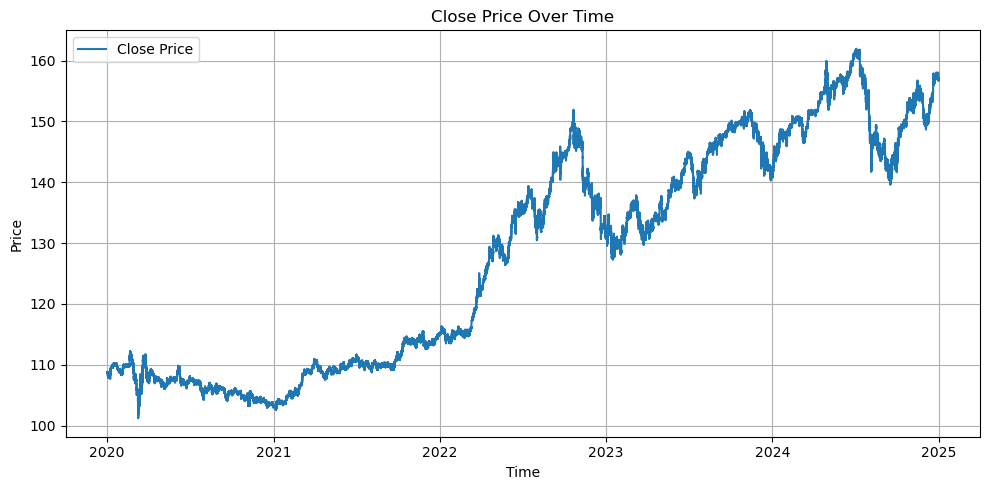

In [55]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['close'], label='Close Price')

plt.title('Close Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


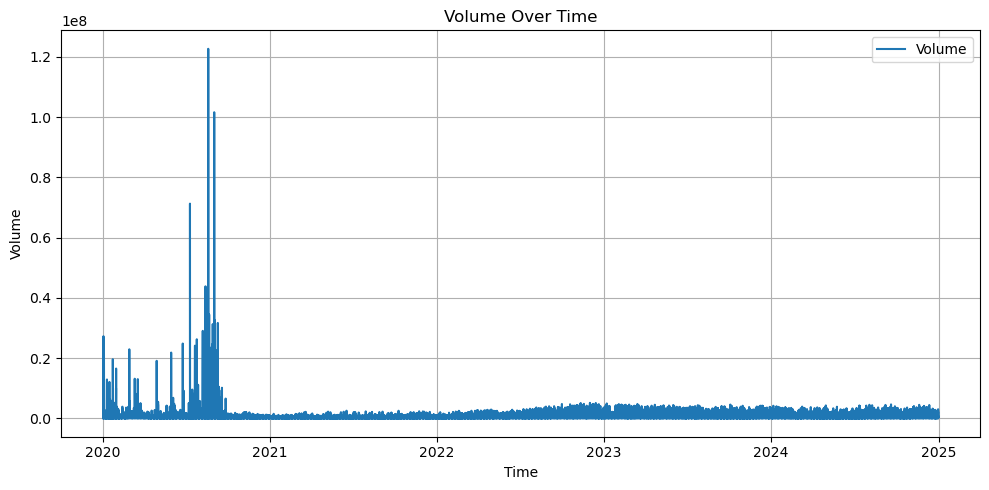

In [56]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['volume'], label='Volume')

plt.title('Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Sample smaller dataset

In [61]:
df = df[df['timestamp'].dt.year >= 2021] # choose 2021+ data for stablized volume
df.shape

(2102400, 6)

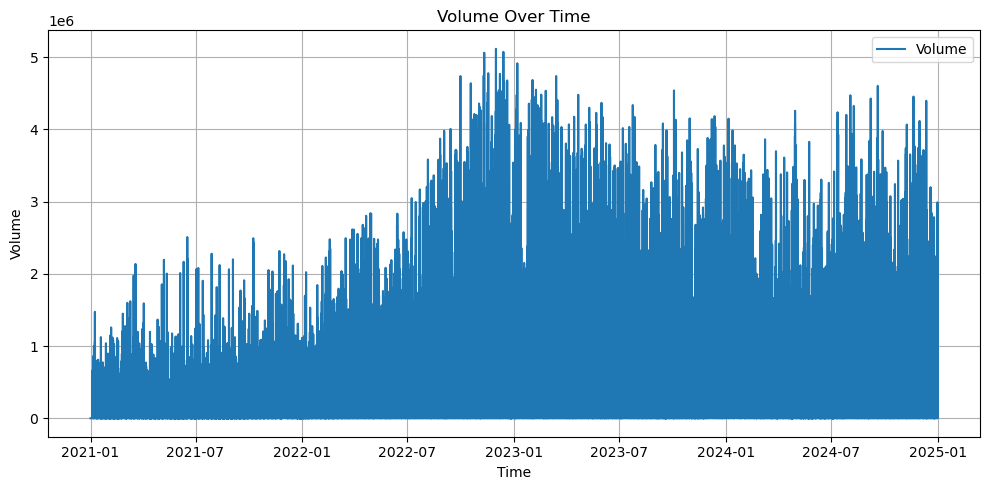

In [58]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['volume'], label='Volume')

plt.title('Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

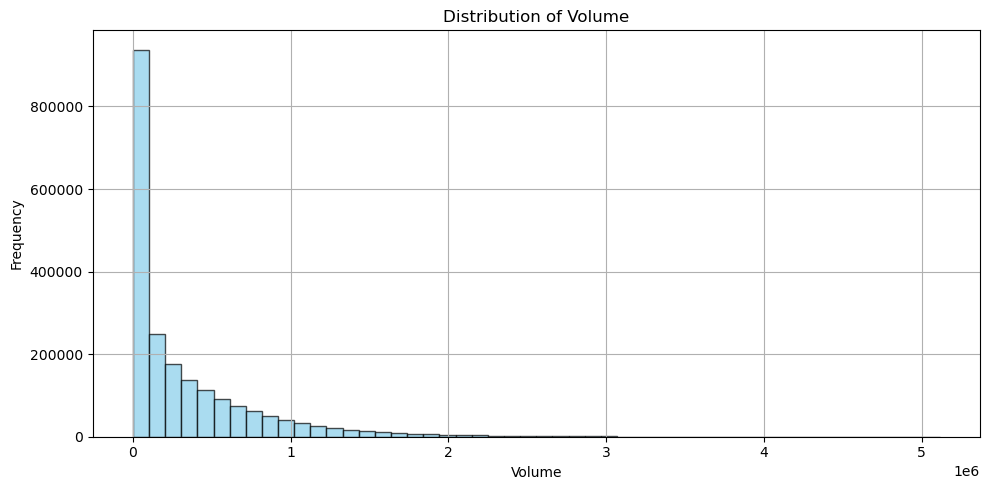

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['volume'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')

plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Dealing with NaN value

In [6]:
df.isna().sum()

timestamp         0
open         767480
high         767480
low          767480
close        767480
volume            0
dtype: int64

In [7]:
df = df.dropna()
df.isna().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

In [8]:
df.shape

(1860640, 6)

# Time grouping

By examining the data, we found that there are timeframes that only include Nan values. After clearing those NaN values, our time series data is no longer continuous, i.e. there're *time gaps*. Therefore, we need to group the data by checking their time continuity and assign *time_group* labels accordingly. This is a necessary process prior to the creation of sequences since *time gaps* can be huge and we don't want to create sequences or calculate indicators across them.

In [9]:
TIME_GAP_TOLERANCE = 60

# Ensure df is a copy (not a view)
df = df.copy()

# Then assign safely
df.loc[:, 'timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.loc[:, 'time_delta'] = df['timestamp'].diff().dt.total_seconds()
df.loc[:, 'time_group'] = (df['time_delta'] != TIME_GAP_TOLERANCE).cumsum().astype(int)
df = df.drop(columns='time_delta')

In [10]:
df.isna().sum()

timestamp     0
open          0
high          0
low           0
close         0
volume        0
time_group    0
dtype: int64

In [11]:
df[['timestamp', 'time_group']]

,timestamp,time_group
0,2020-01-01 22:00:00,1
1,2020-01-01 22:01:00,1
2,2020-01-01 22:02:00,1
3,2020-01-01 22:03:00,1
4,2020-01-01 22:04:00,1
...,...,...
2628115,2024-12-30 23:55:00,7375
2628116,2024-12-30 23:56:00,7375
2628117,2024-12-30 23:57:00,7375
2628118,2024-12-30 23:58:00,7375


In [12]:
df['time_group'].value_counts().sort_values()

time_group
3563       1
4466       1
3461       1
1218       1
1222       1
        ... 
6448    4371
6396    5704
4142    5764
158     6660
164     7200
Name: count, Length: 7375, dtype: int64

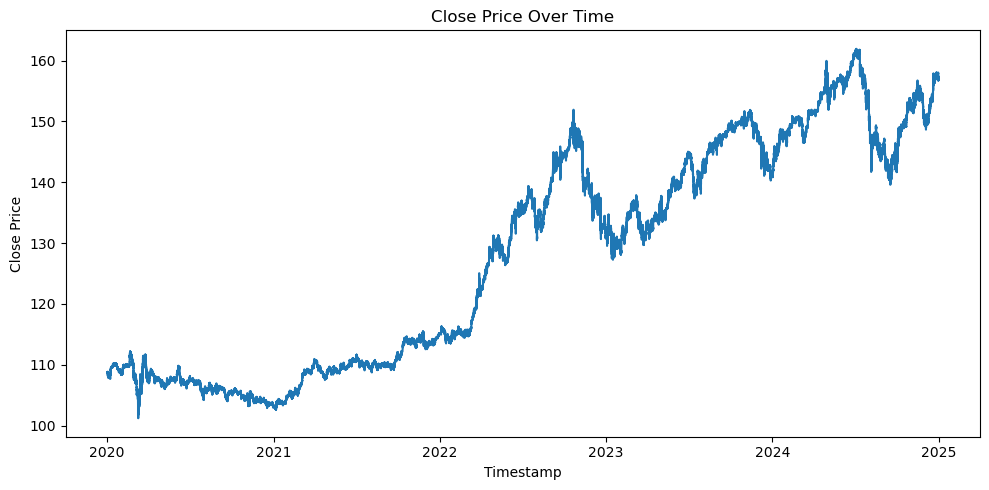

In [13]:
import matplotlib.pyplot as plt

# Group by time_group and plot each with a different color
fig, ax = plt.subplots(figsize=(10,5))


ax.plot(df['timestamp'], df['close'])

ax.set_title('Close Price Over Time')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Close Price')
# ax.legend(title="time_group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


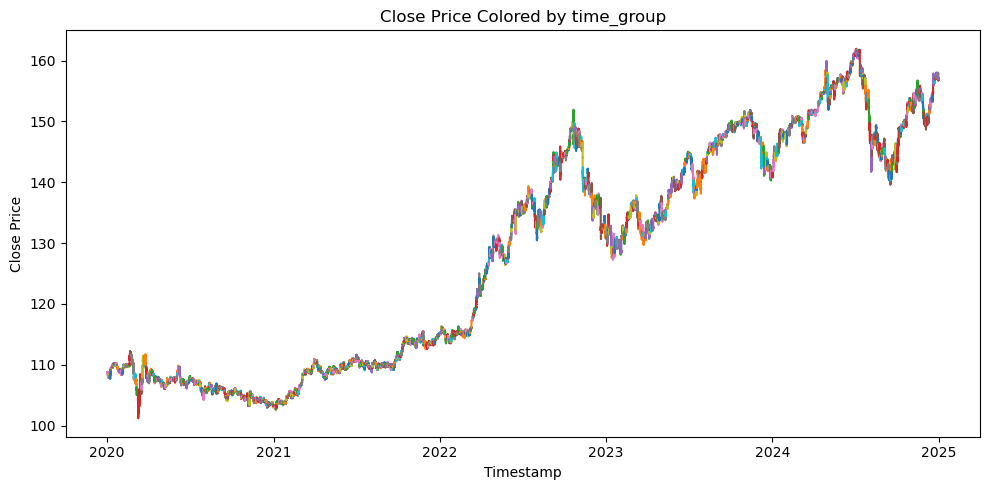

In [14]:
import matplotlib.pyplot as plt

# Group by time_group and plot each with a different color
fig, ax = plt.subplots(figsize=(10,5))

for group_id, group_data in df.groupby('time_group'):
    ax.plot(group_data['timestamp'], group_data['close'], label=f'Group {group_id}')

ax.set_title('Close Price Colored by time_group')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Close Price')
# ax.legend(title="time_group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


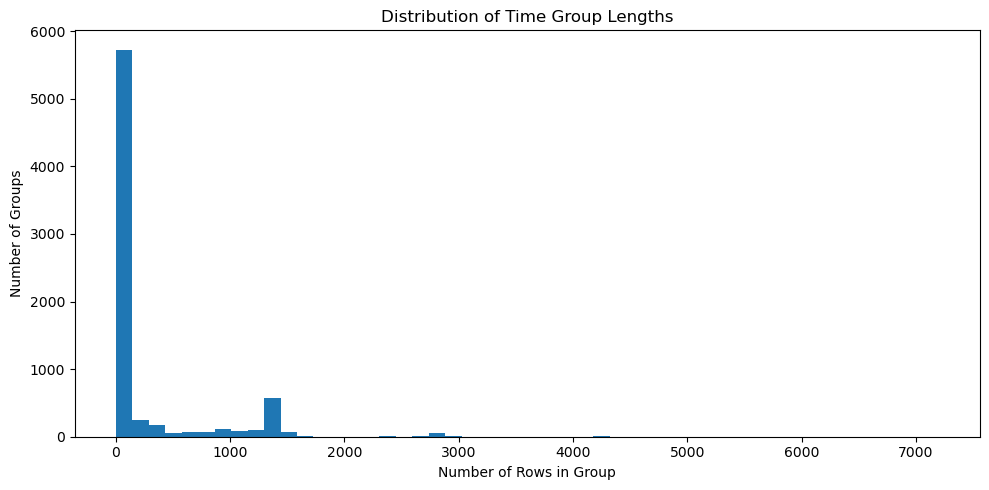

In [15]:
group_lengths = df['time_group'].value_counts()

plt.figure(figsize=(10, 5))
plt.hist(group_lengths, bins=50)
plt.title('Distribution of Time Group Lengths')
plt.xlabel('Number of Rows in Group')
plt.ylabel('Number of Groups')
plt.tight_layout()
plt.show()


# Feature engineering

## Add delta and return

The original price data is non-stationary, we can convert it into stationary data by calculating the difference between each timeframe as *delta* value.
And we are also adding *return* values that indicates the percentage of grow/drop from the last timeframe.
We will do the following process:
1. calculate delta and returns within each timegroup, note that this will result in adding 1 NaN value for each time group and will be dropped later on.
2. labeling the moving **direction** for each row based on the **return** and a given **threshold**
    ```
    'up' if x > threshold else ('down' if x < -threshold else 'flat')
    ```
3. use a global encoder to encode the **direction**, this column will later on be used as target to train our model.

In [16]:
GROUP_COl = 'time_group'

In [17]:
import numpy as np

def add_delta(df, price_col: str = 'close', group_col: str = 'time_group') -> pd.DataFrame:
    df = df.copy()

    def calc(group):
        group[f"{price_col}_delta"] = group[price_col] - group[price_col].shift(1)
        group[f"{price_col}_return"] = group[price_col] / group[price_col].shift(1) - 1
        group[f"{price_col}_log_return"] = np.log(group[price_col] / group[price_col].shift(1))
        return group

    df = df.groupby(group_col, group_keys=False).apply(calc)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df.reset_index(drop=True)


In [18]:
df = add_delta(df)

C:\Users\yoyo\AppData\Local\Temp\ipykernel_13812\3666531097.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_col, group_keys=False).apply(calc)


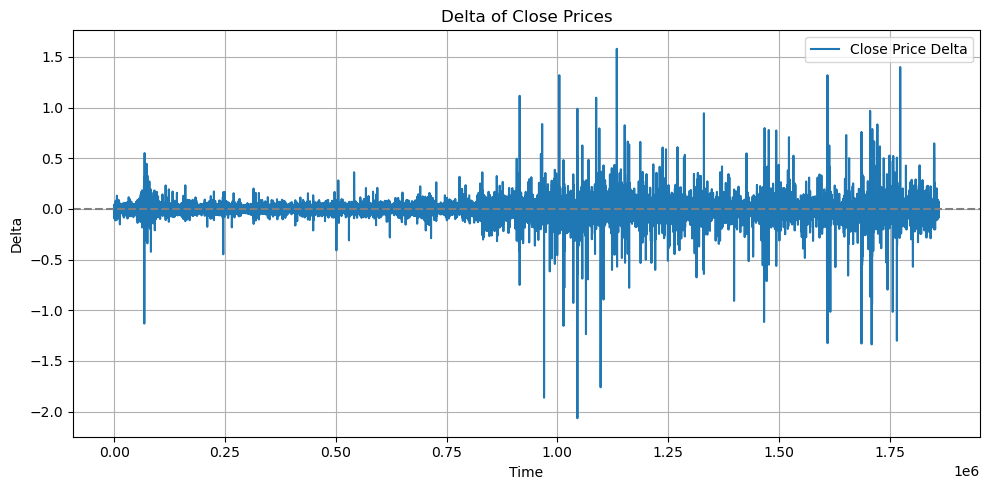

In [19]:
# Plot the delta
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close_delta'], label='Close Price Delta')
plt.axhline(0, color='gray', linestyle='--')  # zero line
plt.title('Delta of Close Prices')
plt.xlabel('Time')
plt.ylabel('Delta')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

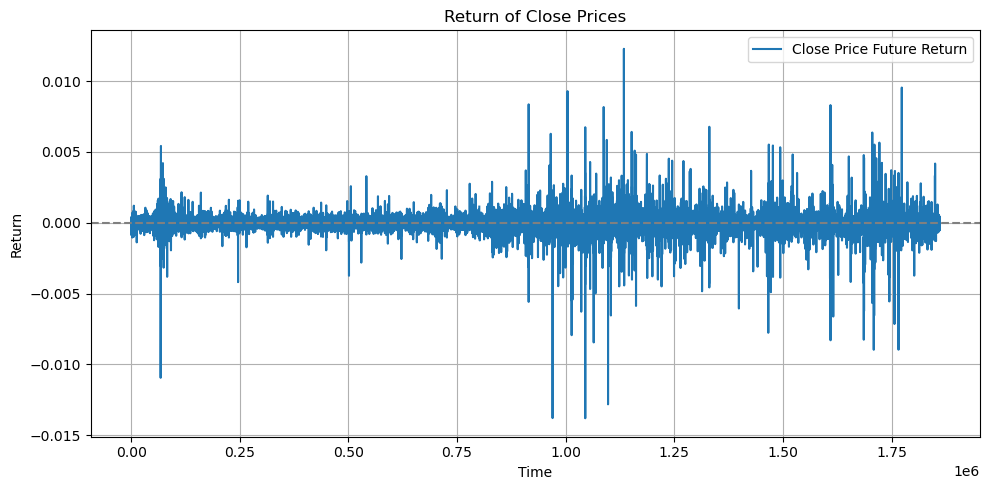

In [20]:
# Plot the return
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close_return'], label='Close Price Future Return')
plt.axhline(0, color='gray', linestyle='--')  # zero line
plt.title('Return of Close Prices')
plt.xlabel('Time')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

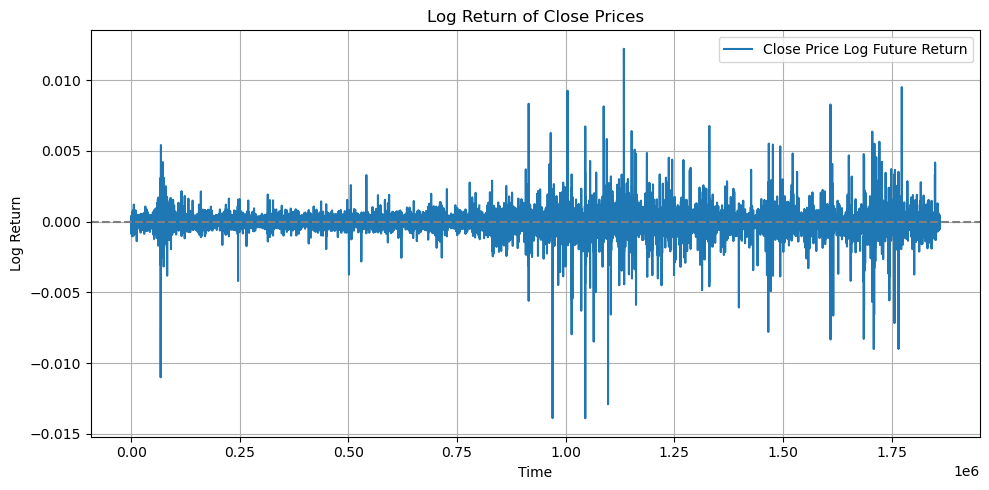

In [21]:
# Plot the return
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close_log_return'], label='Close Price Log Future Return')
plt.axhline(0, color='gray', linestyle='--')  # zero line
plt.title('Log Return of Close Prices')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
df[1000:1200]

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_log_return
1000,2020-01-02 14:47:00,108.6575,108.6580,108.6485,108.6505,1.738600e+06,7,-0.0075,-0.000069,-0.000069
1001,2020-01-02 14:48:00,108.6530,108.6695,108.6530,108.6675,2.520000e+05,7,0.0170,0.000156,0.000156
1002,2020-01-02 14:49:00,108.6670,108.6740,108.6630,108.6680,3.738500e+05,7,0.0005,0.000005,0.000005
1003,2020-01-02 14:50:00,108.6675,108.6755,108.6610,108.6610,2.821400e+05,7,-0.0070,-0.000064,-0.000064
1004,2020-01-02 14:51:00,108.6585,108.6660,108.6550,108.6630,8.620000e+04,7,0.0020,0.000018,0.000018
...,...,...,...,...,...,...,...,...,...,...
1195,2020-01-02 18:02:00,108.5105,108.5115,108.5010,108.5010,7.563000e+04,7,-0.0105,-0.000097,-0.000097
1196,2020-01-02 18:03:00,108.5015,108.5055,108.5000,108.5010,1.517800e+05,7,0.0000,0.000000,0.000000
1197,2020-01-02 18:04:00,108.5005,108.5115,108.4980,108.5115,8.082000e+04,7,0.0105,0.000097,0.000097
1198,2020-01-02 18:05:00,108.5120,108.5220,108.5120,108.5120,1.991000e+05,7,0.0005,0.000005,0.000005


In [23]:
df['time_group'].value_counts().sort_index()

time_group
1       255
2        50
3         7
4        58
5         5
       ... 
7371      1
7372      1
7373      1
7374     28
7375     35
Name: count, Length: 7375, dtype: int64

## Plot histgram

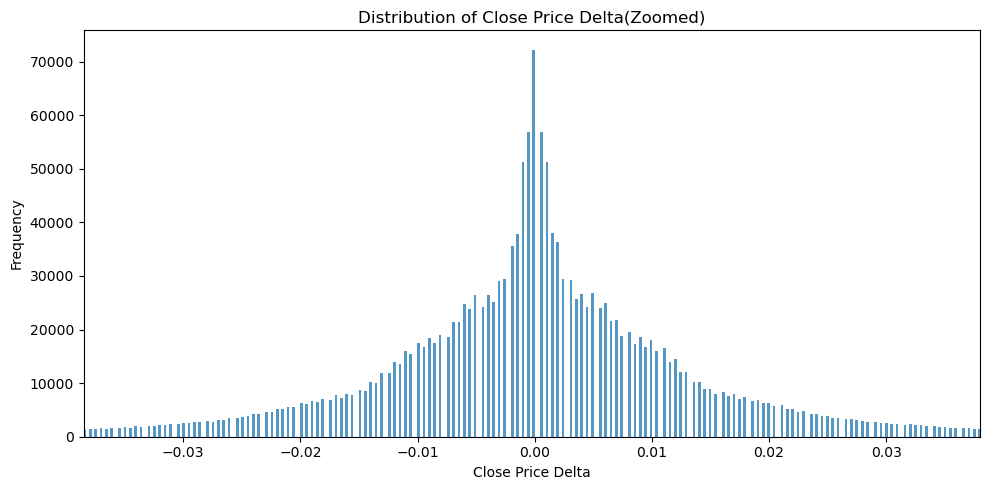

In [24]:
import seaborn as sns

df_copy = df.copy()

low, high = df_copy['close_delta'].quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_delta'])
plt.title("Distribution of Close Price Delta(Zoomed)")
plt.xlabel("Close Price Delta")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

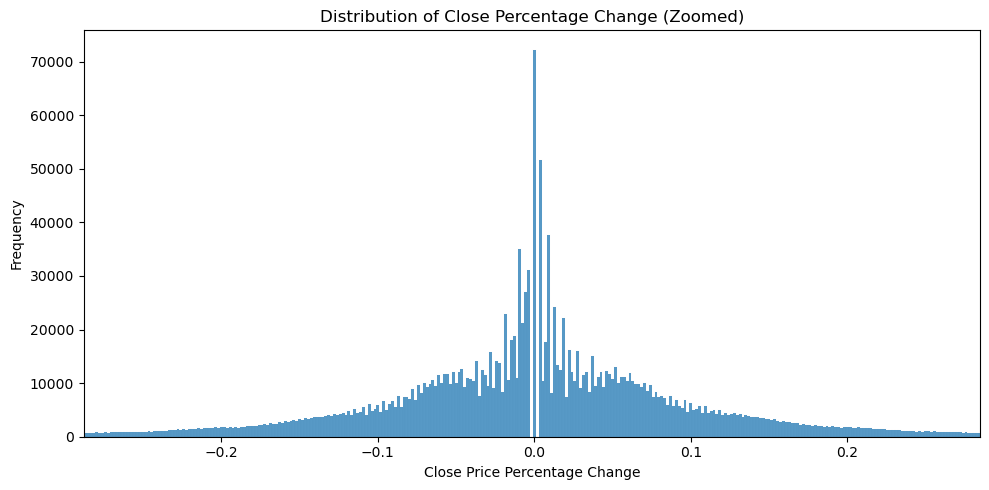

In [25]:
df_copy = df.copy()

low, high = (df_copy['close_return']*1000).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_return']*1000)
plt.title("Distribution of Close Percentage Change (Zoomed)")
plt.xlabel("Close Price Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()



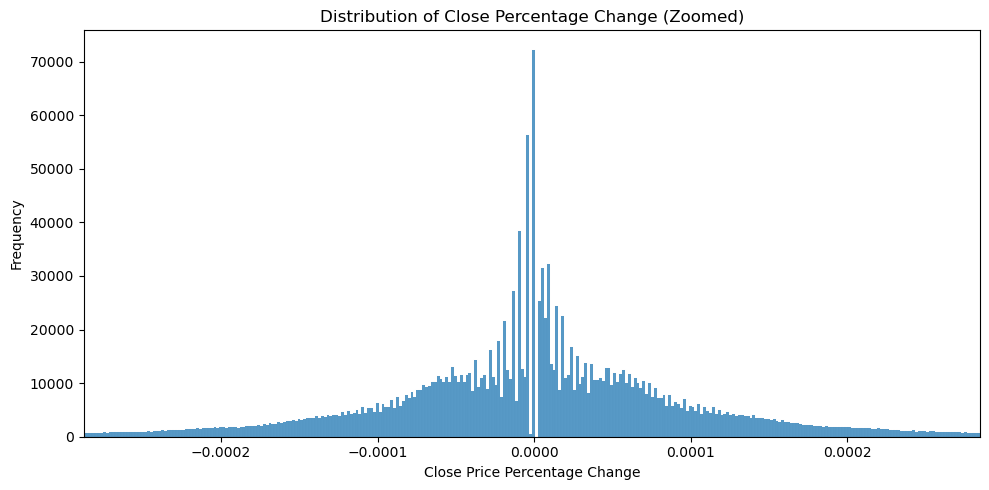

In [26]:
df_copy = df.copy()

low, high = (df_copy['close_log_return']).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_log_return'])
plt.title("Distribution of Close Percentage Change (Zoomed)")
plt.xlabel("Close Price Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

## Calculate average values

In [27]:
df['ret_mean_5'] = (
    df.groupby('time_group')['close_log_return']
    .rolling(window=5, min_periods=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df.head()

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_log_return,ret_mean_5
0,2020-01-01 22:00:00,108.7580,108.7600,108.7580,108.7590,9179.999948,1,NaN,NaN,NaN,NaN
1,2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012,1,-0.0095,-0.000087,-0.000087,NaN
2,2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000,1,0.0040,0.000037,0.000037,NaN
3,2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010,1,0.0020,0.000018,0.000018,NaN
4,2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024,1,0.0095,0.000087,0.000087,NaN


In [28]:
df['ret_mean_10'] = (
    df.groupby('time_group')['close_log_return']
    .rolling(window=10, min_periods=10)
    .mean()
    .reset_index(level=0, drop=True)
)
df.head

<bound method NDFrame.head of                   timestamp      open      high       low     close  \
0       2020-01-01 22:00:00  108.7580  108.7600  108.7580  108.7590   
1       2020-01-01 22:01:00  108.7570  108.7590  108.7495  108.7495   
2       2020-01-01 22:02:00  108.7495  108.7535  108.7495  108.7535   
3       2020-01-01 22:03:00  108.7540  108.7555  108.7535  108.7555   
4       2020-01-01 22:04:00  108.7575  108.7650  108.7555  108.7650   
...                     ...       ...       ...       ...       ...   
1860635 2024-12-30 23:55:00  157.0100  157.0110  157.0075  157.0080   
1860636 2024-12-30 23:56:00  157.0075  157.0090  157.0075  157.0075   
1860637 2024-12-30 23:57:00  157.0035  157.0095  156.9900  157.0070   
1860638 2024-12-30 23:58:00  157.0080  157.0080  157.0000  157.0015   
1860639 2024-12-30 23:59:00  157.0010  157.0085  156.9980  157.0085   

                volume  time_group  close_delta  close_return  \
0          9179.999948           1          NaN     

## Drop NaN

In [29]:
df.isna().sum()

timestamp               0
open                    0
high                    0
low                     0
close                   0
volume                  0
time_group              0
close_delta          7375
close_return         7375
close_log_return     7375
ret_mean_5          31081
ret_mean_10         55035
dtype: int64

In [30]:
df = df.dropna()
df.isna().sum()

timestamp           0
open                0
high                0
low                 0
close               0
volume              0
time_group          0
close_delta         0
close_return        0
close_log_return    0
ret_mean_5          0
ret_mean_10         0
dtype: int64

## Classification Labeling

## Add direction

In [31]:
def add_direction(df, delta_columns=['close'], threshold=0.005):
    """
    Add directional class labels based on deltas and a threshold.
    """
    df = df.copy()
    
    for col in delta_columns:
        df[f"{col}_direction"] =  df[f"{col}_log_return"].apply(lambda x: 'up' if x > threshold else ('down' if x < -threshold else 'flat'))
    return df

In [32]:
df = add_direction(df, threshold=3e-5)

In [33]:
df['close_direction'].value_counts()

close_direction
up      621785
down    611910
flat    571910
Name: count, dtype: int64

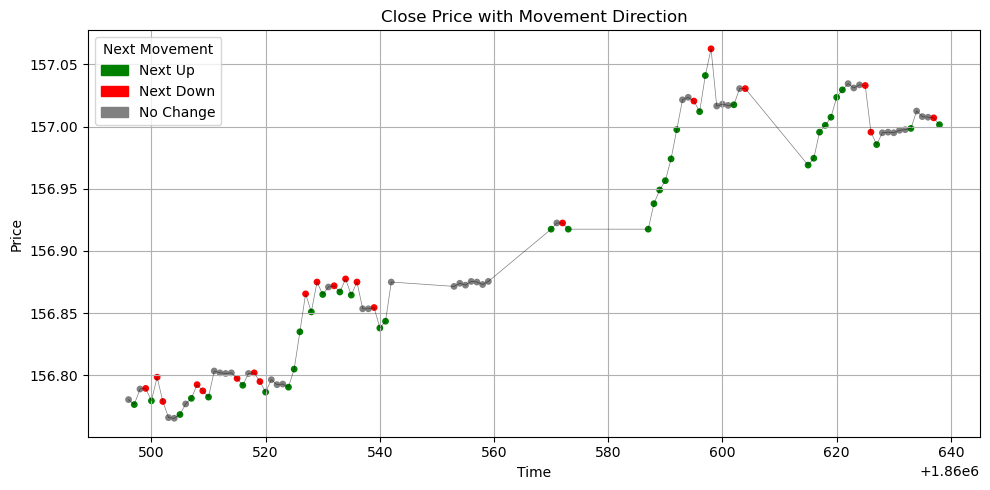

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Slice and shift for next movement direction
df_filtered = df[-101:].copy()
df_filtered['next_direction'] = df_filtered['close_direction'].shift(-1)
df_filtered = df_filtered[:-1]  # Drop the last row where next_direction is NaN

# Plot
plt.figure(figsize=(10, 5))

# Color map
colors = df_filtered['next_direction'].map({'up': 'green', 'down': 'red', 'flat': 'gray'})

# Plot scatter and line
plt.scatter(df_filtered.index, df_filtered['close'], c=colors, s=15)
plt.plot(df_filtered.index, df_filtered['close'], color='black', linewidth=0.5, alpha=0.5)

# Create manual legend
legend_patches = [
    mpatches.Patch(color='green', label='Next Up'),
    mpatches.Patch(color='red', label='Next Down'),
    mpatches.Patch(color='gray', label='No Change'),
]
plt.legend(handles=legend_patches, title='Next Movement')

# Final formatting
plt.title('Close Price with Movement Direction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()


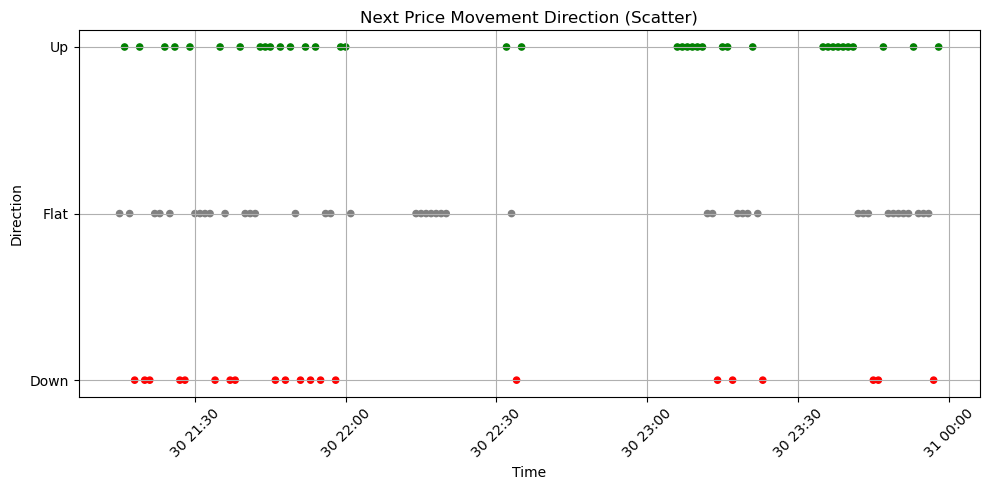

In [35]:
import matplotlib.pyplot as plt

# Slice and compute next direction
df_filtered = df[-101:].copy()
df_filtered['next_direction'] = df_filtered['close_direction'].shift(-1)
df_filtered = df_filtered[:-1]

# Map direction to y-axis position and color
direction_to_y = {'down': -1, 'flat': 0, 'up': 1}
direction_to_color = {'up': 'green', 'down': 'red', 'flat': 'gray'}

df_filtered['direction_y'] = df_filtered['next_direction'].map(direction_to_y)
colors = df_filtered['next_direction'].map(direction_to_color)

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(df_filtered['timestamp'], df_filtered['direction_y'], c=colors, s=20)

# Customize y-axis with labels
plt.yticks([-1, 0, 1], ['Down', 'Flat', 'Up'])

# Format time axis
plt.xlabel('Time')
plt.ylabel('Direction')
plt.title('Next Price Movement Direction (Scatter)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [36]:
df.head()

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_log_return,ret_mean_5,ret_mean_10,close_direction
10,2020-01-01 22:10:00,108.7455,108.7480,108.7430,108.7450,145529.998422,1,-0.0010,-0.000009,-0.000009,-4.597384e-05,-0.000013,flat
11,2020-01-01 22:11:00,108.7445,108.7470,108.7395,108.7400,56379.999280,1,-0.0050,-0.000046,-0.000046,-3.126480e-05,-0.000009,down
12,2020-01-01 22:12:00,108.7340,108.7600,108.7340,108.7575,95219.999909,1,0.0175,0.000161,0.000161,-1.320558e-17,0.000004,up
13,2020-01-01 22:13:00,108.7600,108.7600,108.6495,108.7475,233979.999036,1,-0.0100,-0.000092,-0.000092,-1.287344e-05,-0.000007,down
14,2020-01-01 22:14:00,108.7455,108.7475,108.7445,108.7450,139499.999642,1,-0.0025,-0.000023,-0.000023,-1.839157e-06,-0.000018,flat


## Label encoding

## One Hot Encoding

In [37]:
# One-hot encode with get_dummies
one_hot = pd.get_dummies(df['close_direction'], prefix='prob').astype('float32')

df = df.join(one_hot)

df.head

<bound method NDFrame.head of                   timestamp      open      high       low     close  \
10      2020-01-01 22:10:00  108.7455  108.7480  108.7430  108.7450   
11      2020-01-01 22:11:00  108.7445  108.7470  108.7395  108.7400   
12      2020-01-01 22:12:00  108.7340  108.7600  108.7340  108.7575   
13      2020-01-01 22:13:00  108.7600  108.7600  108.6495  108.7475   
14      2020-01-01 22:14:00  108.7455  108.7475  108.7445  108.7450   
...                     ...       ...       ...       ...       ...   
1860635 2024-12-30 23:55:00  157.0100  157.0110  157.0075  157.0080   
1860636 2024-12-30 23:56:00  157.0075  157.0090  157.0075  157.0075   
1860637 2024-12-30 23:57:00  157.0035  157.0095  156.9900  157.0070   
1860638 2024-12-30 23:58:00  157.0080  157.0080  157.0000  157.0015   
1860639 2024-12-30 23:59:00  157.0010  157.0085  156.9980  157.0085   

                volume  time_group  close_delta  close_return  \
10       145529.998422           1      -0.0010     

In [38]:
from sklearn.preprocessing import LabelEncoder

def add_label(df, class_col='direction'):
    """
    Add directional class labels based on deltas and a threshold.
    """
    df = df.copy()
    
    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df[class_col])
    direction_counts = df["label"].value_counts()
    print(direction_counts)
    print(label_encoder.classes_)
    return df, label_encoder

In [39]:
df, encoder = add_label(df, class_col='close_direction')

label
2    621785
0    611910
1    571910
Name: count, dtype: int64
['down' 'flat' 'up']


In [40]:
import joblib

ENCODER_PATH = '../data/processed/label_encoder.pkl'

joblib.dump(encoder, ENCODER_PATH)

['../data/processed/label_encoder.pkl']

In [41]:
df.head()

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_log_return,ret_mean_5,ret_mean_10,close_direction,prob_down,prob_flat,prob_up,label
10,2020-01-01 22:10:00,108.7455,108.7480,108.7430,108.7450,145529.998422,1,-0.0010,-0.000009,-0.000009,-4.597384e-05,-0.000013,flat,0.0,1.0,0.0,1
11,2020-01-01 22:11:00,108.7445,108.7470,108.7395,108.7400,56379.999280,1,-0.0050,-0.000046,-0.000046,-3.126480e-05,-0.000009,down,1.0,0.0,0.0,0
12,2020-01-01 22:12:00,108.7340,108.7600,108.7340,108.7575,95219.999909,1,0.0175,0.000161,0.000161,-1.320558e-17,0.000004,up,0.0,0.0,1.0,2
13,2020-01-01 22:13:00,108.7600,108.7600,108.6495,108.7475,233979.999036,1,-0.0100,-0.000092,-0.000092,-1.287344e-05,-0.000007,down,1.0,0.0,0.0,0
14,2020-01-01 22:14:00,108.7455,108.7475,108.7445,108.7450,139499.999642,1,-0.0025,-0.000023,-0.000023,-1.839157e-06,-0.000018,flat,0.0,1.0,0.0,1


# Timegroup Filtering

Before creating sequences, we have to make sure every **time group** have enough data to create at least **1** sequence.
Given the sequence length is X, horizon is H, each time group must have at least X + H timeframes. 

In [42]:
SEQ_LEN = 30
HORIZON = 1

min_len = SEQ_LEN + HORIZON

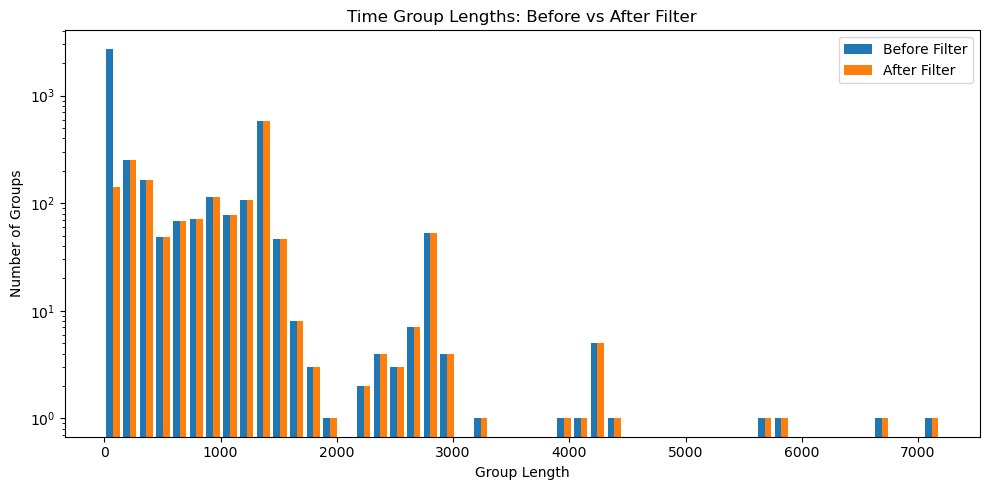

In [43]:
lengths = df['time_group'].value_counts()
before = lengths
after = lengths[lengths >= 100]

plt.figure(figsize=(10, 5))
plt.hist([before, after], bins=50, label=['Before Filter', 'After Filter'], stacked=False, log=True)
plt.title('Time Group Lengths: Before vs After Filter')
plt.xlabel('Group Length')
plt.ylabel('Number of Groups')
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
df = df.groupby("time_group").filter(lambda g: len(g) >= min_len)

In [45]:
df['time_group'].nunique()

2583

In [46]:
df['time_group'].value_counts()

time_group
164     7190
158     6650
4142    5754
6396    5694
6448    4361
        ... 
2578      31
3403      31
1668      31
5977      31
5770      31
Name: count, Length: 2583, dtype: int64

In [51]:
df.head()

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_log_return,ret_mean_5,ret_mean_10,close_direction,prob_down,prob_flat,prob_up,label
10,2020-01-01 22:10:00,108.7455,108.7480,108.7430,108.7450,145529.998422,1,-0.0010,-0.000009,-0.000009,-4.597384e-05,-0.000013,flat,0.0,1.0,0.0,1
11,2020-01-01 22:11:00,108.7445,108.7470,108.7395,108.7400,56379.999280,1,-0.0050,-0.000046,-0.000046,-3.126480e-05,-0.000009,down,1.0,0.0,0.0,0
12,2020-01-01 22:12:00,108.7340,108.7600,108.7340,108.7575,95219.999909,1,0.0175,0.000161,0.000161,-1.320558e-17,0.000004,up,0.0,0.0,1.0,2
13,2020-01-01 22:13:00,108.7600,108.7600,108.6495,108.7475,233979.999036,1,-0.0100,-0.000092,-0.000092,-1.287344e-05,-0.000007,down,1.0,0.0,0.0,0
14,2020-01-01 22:14:00,108.7455,108.7475,108.7445,108.7450,139499.999642,1,-0.0025,-0.000023,-0.000023,-1.839157e-06,-0.000018,flat,0.0,1.0,0.0,1


# Saving the file

In [47]:


df.to_pickle(PROCESSED_FILE_PATH)

# Exploration

In [48]:
labels = df['label']
labels[:100]

10     1
11     0
12     2
13     0
14     1
      ..
105    2
106    2
107    2
108    0
109    2
Name: label, Length: 100, dtype: int64

In [49]:
from_ = labels[:-1]
to_ = labels[1:]

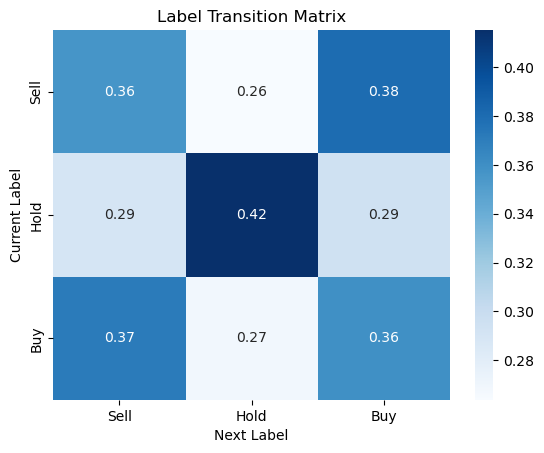

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

n_classes = len(set(labels))
matrix = np.zeros((n_classes, n_classes), dtype=int)

for i, j in zip(from_, to_):
    matrix[i, j] += 1

# Normalize rows to get probabilities
matrix_normalized = matrix / matrix.sum(axis=1, keepdims=True)

# Plot
sns.heatmap(matrix_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Sell', 'Hold', 'Buy'], yticklabels=['Sell', 'Hold', 'Buy'])
plt.xlabel('Next Label')
plt.ylabel('Current Label')
plt.title('Label Transition Matrix')
plt.show()